## Chapter 3

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from math import factorial

class PauliAlgebra:
    '''
        Pauli matrices and generalized Pauli matrices
    '''
    def __init__(self, n:int):
        '''n is the dimension of pauli matrices'''
        self.n = n

    def get_creation_operator(self)->np.ndarray:
        '''in Fock space'''
        a = np.diag(np.sqrt(np.arange(1,self.n)), k=-1)
        return a
    
    def get_annihilation_operator(self)->np.ndarray:
        '''in Fock space'''
        adag = np.diag(np.sqrt(np.arange(1,self.n)), k=1)
        return adag
    
    def get_number_operator(self)->np.ndarray:
        return np.diag(np.arange(0,self.n))

    def get_basis(self)->np.ndarray:
        '''generalized Pauli'''
        basis = []
        for j in range(self.n - 1):
            # symmetric
            for k in range(j+1, self.n):
                temp = np.zeros((self.n, self.n),dtype=complex)
                temp2 = np.zeros((self.n, self.n),dtype=complex)
                temp[j,k] = 1
                temp2[k,j] = 1
                basis.append((temp + temp2) / np.sqrt(2.))

        for j in range(self.n - 1):
            # anti-symmetric
            for k in range(j+1, self.n):
                temp = np.zeros((self.n, self.n),dtype=complex)
                temp2 = np.zeros((self.n, self.n),dtype=complex)
                temp[j,k] = 1
                temp2[k,j] = 1
                basis.append(((temp - temp2) * -1j) / np.sqrt(2.))

        for l in range(1, self.n):
            # diagonal
            _sum = np.zeros((self.n, self.n),dtype=complex)
            temp = np.zeros((self.n, self.n),dtype=complex)
            for j in range(l):
                tempp = np.zeros((self.n, self.n),dtype=complex)
                tempp[j,j] = 1
                _sum += tempp
            temp[l,l] = 1
            basis.append((np.sqrt(2. / l / (l+1)) * (_sum - l * temp)) / np.sqrt(2.))

        # last pauli matrix is identity, scaled by 1/sqrt(n), others are scaled by 1/sqrt(2.)
        basis.append(np.identity(self.n,dtype=complex) / np.sqrt(self.n))
        basis = np.array(basis)
        basis_flattened = np.array([ibasis.flatten() for ibasis in basis])
        return basis, basis_flattened

    
class DensityMatrix:
    def __init__(self, state_vec:np.ndarray=None, ndim_A:int=None, ndim_B:int=None):
        if state_vec is not None:
            if not isinstance(state_vec, np.ndarray):
                state_vec = np.ndarray(state_vec)
            _norm = np.sqrt(np.dot(state_vec.conjugate(), state_vec))
            state_vec /= _norm
            self.state_vec = state_vec
            self.dm = np.outer(state_vec, np.conjugate(state_vec))
            self.ndim_A = ndim_A
            self.ndim_B = ndim_B
        elif state_vec is None:
            self.state_vec = None
            self.dm = None
            self.ndim_A = None
            self.ndim_B = None

    def partial_trace2(self, trace_out:str)->np.ndarray:
        '''
            two subsystems only
            trace_out='A' means TrA(rho), trace out 'A', leaving subsystem 'B'
        '''
        if self.dm is None:
            raise ValueError("density matrix is None!")
        
        basis_A = np.identity(self.ndim_A)
        basis_B = np.identity(self.ndim_B)

        if trace_out == 'A':
            dm_reduced = np.zeros((self.ndim_B, self.ndim_B), dtype=complex)
            identity = np.identity(self.ndim_B)
            for basis in basis_A:
                dm_reduced += np.kron(np.reshape(basis.conjugate(), (1, self.ndim_A)), identity) @ \
                self.dm @ \
                np.kron(np.reshape(basis, (self.ndim_A, 1)), identity)
        elif trace_out == 'B':
            dm_reduced = np.zeros((self.ndim_A, self.ndim_A), dtype=complex)
            identity = np.identity(self.ndim_A)
            for basis in basis_B:
                dm_reduced += np.kron(identity, np.reshape(basis.conjugate(), (1, self.ndim_B))) @ \
                self.dm @ \
                np.kron(identity, np.reshape(basis, (self.ndim_B, 1)))
        else:
            raise ValueError("trace out is 'A' or 'B'")
        return dm_reduced
    
    def time_evolution(self, t_vals:np.ndarray, hamiltonian:np.ndarray, hbar:float=1.)->list:
        '''return density matrix at each time point'''
        if not isinstance(t_vals, np.ndarray):
            t_vals = np.array(t_vals, dtype=float)
        if not isinstance(hamiltonian, np.ndarray):
            hamiltonian = np.array(hamiltonian, dtype=complex)
            if not all(np.isclose((hamiltonian - np.transpose(np.conjugate(hamiltonian))).flatten(), 0. + 0.j)):
                raise ValueError("input hamiltonian is not hermitian!")
        if hamiltonian.shape != self.dm.shape:
            raise ValueError("Hamiltonian and density matrix dimensions don't match!")
        dm_t = []
        for t in t_vals:
            unitary = expm(-1j / hbar * t * hamiltonian)
            dm_t.append(unitary @ self.dm @ np.transpose(np.conjugate(unitary)))
        return dm_t        

# def isPure(mat:np.ndarray)->bool:
#     if not isinstance(mat, np.ndarray):
#         mat = np.array(mat)
#     mat2 = mat @ mat
#     if np.isclose(np.trace(mat), 1.) and np.isclose(np.trace(mat2), 1.):
#         return True
#     if np.isclose(np.trace(mat), 1.) and 0. < np.trace(mat2) < 1.:
#         return False
#     else:
#         raise ValueError("not a valid density matrix")

In [9]:
'''test'''

# pauli = PauliAlgebra(n=2)
# basis, _ = pauli.get_basis()
# basis[:-1] *= np.sqrt(2.)
# basis[-1] *= np.sqrt(2.)
# sigma_x, sigma_y, sigma_z, identity = basis
# omega = 1.
# hamiltonian = omega / 2. * sigma_z + 0.5 * sigma_x + 0.3 * sigma_y # generalized Hamiltonian
# t_vals = np.linspace(0, 10, 200, endpoint=True)

# state0 = np.array([1,0])
# state1 = np.array([0,1])
# f0 = np.sqrt(2.) * (state0 + state1)
# dm = DensityMatrix(state_vec=f0)
# dm_t = dm.time_evolution(t_vals=t_vals, hamiltonian=hamiltonian)

# p0 = [d[0,0].real for d in dm_t]
# p1 = [d[1,1].real for d in dm_t]
# mean_sigma_x = [np.trace(d @ sigma_x).real for d in dm_t]
# mean_sigma_y = [np.trace(d @ sigma_y).real for d in dm_t]
# mean_sigma_z = [np.trace(d @ sigma_z).real for d in dm_t]

# plt.plot(t_vals, p0)
# plt.plot(t_vals, p1)
# plt.plot(t_vals, [i+j for i,j in zip(p0,p1)])
# plt.legend(["p0","p1","p0+p1"])
# plt.show()
# plt.plot(t_vals, mean_sigma_x)
# plt.plot(t_vals, mean_sigma_y)
# plt.plot(t_vals, mean_sigma_z)
# plt.legend([r"$\langle \sigma_x \rangle$", r"$\langle \sigma_y \rangle$", r"$\langle \sigma_z \rangle$"])
# plt.show()

'test'

**Spin-boson Hamiltonian**
$$H = H_S + H_B + H_{SB} = \frac{\Delta}{2}\sigma_x \otimes I + I \otimes \sum_i \omega_i a_i^\dagger a_i + \frac{\sigma_z}{2} \otimes \sum_i c_i x_i$$

- system part, simple 2-level system: $H_S = \frac{\Delta}{2}\sigma_x$, eigenvalues $\pm\frac{\Delta}{2}$, energy splitting $\Delta$
- bath part, multiple mode qho, mode frequency: $\omega_i$: $H_B = \sum_i\omega_i a_i^\dagger a_i$
- coupling part: $\frac{\sigma_z}{2}\sum_i c_i x_i$

one mode ho, zero-coupling leads to
$$\begin{split}
    & H = \frac{\Delta}{2}\sigma_x \otimes I + I \otimes \omega a^\dagger a \\
\end{split}$$

coherent state of ho in Fock space
$$|\alpha\rangle = e^{-\frac{|\alpha|^2}{2}} \sum_{n=0}^\infty \frac{\alpha^n}{\sqrt{n!}} |n\rangle$$

Composite state vector
$$|\psi\rangle = |1\rangle \otimes |f_\text{coh}\rangle = \begin{bmatrix} 0 \\ 1 \\\end{bmatrix}\otimes |f_\text{coh}\rangle = \begin{bmatrix}0\cdot |f_\text{coh}\rangle \\ 1\cdot |f_\text{coh}\rangle \\\end{bmatrix}$$

**state vector formalism**

In [40]:
# Pauli basis
pauli = PauliAlgebra(n=2)
basis, _ = pauli.get_basis()
basis *= np.sqrt(2.)
sigma_x, sigma_y, sigma_z, _ = basis

# parameters
hbar = 1.
omega = 1.
delta = 1.
m = 1.
alpha = -1.5
ndim_bath = 20 # truncation
t_vals = np.arange(0., 8. * np.pi + 0.1, 0.1)

# system
f0_sys = np.array([0,1])
H_sys = np.kron(delta / 2 * sigma_x, np.identity(ndim_bath))

# bath
basis_bath = np.identity(ndim_bath)
f0_bath = np.zeros((ndim_bath,), dtype=complex)
for n in range(ndim_bath):
    f0_bath += np.power(alpha, n) / np.sqrt(factorial(n)) * basis_bath[n]
f0_bath *= np.exp(-alpha * alpha.conjugate() / 2.)
H_bath = np.kron(np.identity(2), omega * np.diag(np.arange(0, ndim_bath)))

# composite
f0_tot = np.zeros((ndim_bath * 2), dtype=complex)
for n in range(ndim_bath):
    f0_tot += np.power(alpha, n) / np.sqrt(factorial(n)) * np.kron(f0_sys, basis_bath[n])
f0_tot *= np.exp(-alpha * alpha.conjugate() / 2.)
H_tot = H_sys + H_bath

In [41]:
u_tot_t = np.array([expm(-1j / hbar * H_tot * t_val) for t_val in t_vals])
u_sys_t = np.array([expm(-1j / hbar * (delta / 2 * sigma_x) * t) for t in t_vals])
u_bath_t = np.array([expm(-1j / hbar * (omega * np.diag(np.arange(0, ndim_bath))) * t) for t in t_vals])

f_sys_t = np.array([u @ f0_sys for u in u_sys_t])
f_bath_t = np.array([u @ f0_bath for u in u_bath_t])
f_tot_t = np.array([u @ f0_tot for u in u_tot_t])

p0 = np.array([np.dot(f[:ndim_bath], f[:ndim_bath].conjugate()).real for f in f_tot_t])
p1 = np.array([np.dot(f[ndim_bath:], f[ndim_bath:].conjugate()).real for f in f_tot_t])

p_system = np.array([np.dot(f, f.conjugate()).real for f in f_sys_t]) # |f_sys|^2
p_bath = np.array([np.dot(f, f.conjugate()).real for f in f_bath_t]) # |f_bath|^2

In [23]:
# plt.plot(t_vals, p0)
# plt.plot(t_vals, p1)
# plt.legend(["p0","p1"])
# plt.show()

# plt.plot(t_vals, p_system,)
# plt.plot(t_vals, p_bath, '--')
# plt.legend([r"$|f_{\text{sys}}|^2$", r"$|f_\text{bath}|^2$"])
# plt.ylim((0,2))
# plt.show()

**Density matrix formalism**

In [43]:
dm_tot = DensityMatrix(state_vec=f0_tot, ndim_A=2, ndim_B=ndim_bath)
dm_A = dm_tot.partial_trace2(trace_out='B')
dm_B = dm_tot.partial_trace2(trace_out='A')

dm_tot_t = dm_tot.time_evolution(t_vals=t_vals, hamiltonian=H_tot)
dm_A_t = []
dm_B_t = []

dm_tmp = DensityMatrix()
for d in dm_tot_t:
    dm_tmp.ndim_A = 2
    dm_tmp.ndim_B = ndim_bath
    dm_tmp.dm = d
    dm_B_t.append(dm_tmp.partial_trace2('A'))
    dm_A_t.append(dm_tmp.partial_trace2('B'))

p0 = [sum(np.diagonal(d)[:ndim_bath]).real for d in dm_tot_t]
p1 = [sum(np.diagonal(d)[ndim_bath:]).real for d in dm_tot_t]
p0_A = [rho[0,0].real for rho in dm_A_t]
p1_A = [rho[1,1].real for rho in dm_A_t]

p0_B = [sum(np.diagonal(rho)[:ndim_bath]).real for rho in dm_B_t]
p1_B = [sum(np.diagonal(rho)[ndim_bath:]).real for rho in dm_B_t]

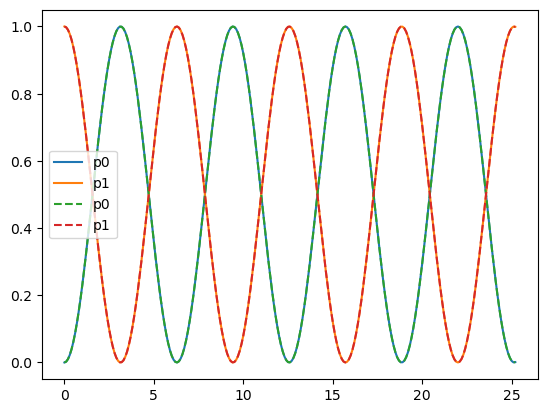

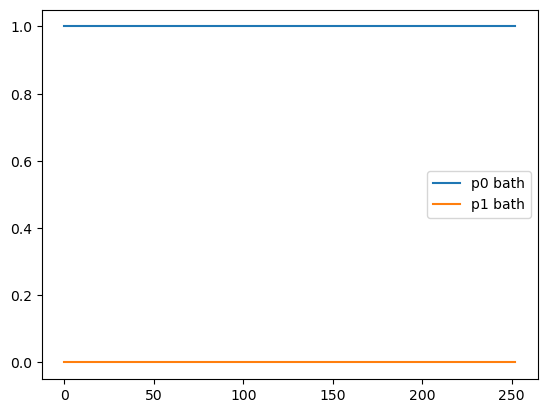

In [44]:
plt.plot(t_vals, p0)
plt.plot(t_vals, p1)
plt.plot(t_vals, p0_A, '--')
plt.plot(t_vals, p1_A, '--')
plt.legend(["p0","p1", "p0", "p1"])
plt.show()

plt.plot(p0_B)
plt.plot(p1_B)
plt.legend(["p0 bath", "p1 bath"])
plt.show()

**Non-zero coupling**

$$H = \frac{\Delta}{2}\sigma_x \otimes I + I \otimes \omega a^\dagger a + \frac{\sigma_z}{2} \otimes c x$$

$$|\alpha\rangle = e^{-\frac{|\alpha|^2}{2}} \sum_{n=0}^\infty \frac{\alpha^n}{\sqrt{n!}} |n\rangle$$

$$x_i = \sqrt{\frac{\hbar}{2m\omega}}\left(a_i + a_i^\dagger \right)$$

$$\begin{split}
    & a^\dagger = \begin{bmatrix}
        0 & 0 & 0 & 0 & 0 & \cdots \\
        1 & 0 & 0 & 0 & 0 & \cdots \\
        0 & \sqrt{2} & 0 & 0 & 0 & \cdots \\
        0 & 0 & \sqrt{3}  & 0 & 0 & \cdots \\
        0 & 0 & 0 & \sqrt{4}  & 0 & \cdots \\
        0 & 0 & 0 & 0 & \sqrt{5} & \cdots \\
        \vdots  & \vdots  & \vdots  & \vdots  & \vdots & \ddots \\
    \end{bmatrix} \\
    & a = \begin{bmatrix}
        0 & 1 & 0 & 0 & 0 & 0 & \cdots \\
        0 & 0 & \sqrt{2} & 0 & 0 & 0 & \cdots \\
        0 & 0 & 0 & \sqrt{3} & 0 & 0 & \cdots \\
        0 & 0 & 0 & 0 & \sqrt{4} & 0 & \cdots \\
        0 & 0 & 0 & 0 & 0 & \sqrt{5} & \cdots \\
        \vdots  & \vdots  & \vdots  & \vdots  & \vdots & \vdots & \ddots \\
        \end{bmatrix} \\
\end{split}$$

$$\begin{split}
    & |\psi\rangle = |1\rangle \otimes |f^\text{coh}\rangle \\
    & H_{SB} = \frac{\sigma_z}{2} c \hat{x} = \frac{c}{2}\sqrt{\frac{\hbar}{2m\omega}} \sigma_z \otimes \left(\hat{a} + \hat{a^\dagger}\right) \\
\end{split}$$

In [47]:
bath = PauliAlgebra(n=ndim_bath)
creation = bath.get_creation_operator()
annihilation = bath.get_annihilation_operator()

coupling = 0.8
H_int = coupling / 2. * np.kron(sigma_z, creation + annihilation)
H_tot = H_tot + H_int

dm = DensityMatrix(state_vec=f0_tot, ndim_A=2, ndim_B=ndim_bath)
dm_t = dm.time_evolution(t_vals=t_vals, hamiltonian=H_tot)

u_t = [expm(-1j / hbar * t_val * H_tot) for t_val in t_vals]
f_tot_t = [u @ f0_tot for u in u_t]

p0 = [sum(np.diagonal(d)[:ndim_bath]).real for d in dm_t]
p1 = [sum(np.diagonal(d)[ndim_bath:]).real for d in dm_t]
pp0 = [np.dot(f[:ndim_bath], f[:ndim_bath].conjugate()).real for f in f_tot_t]
pp1 = [np.dot(f[ndim_bath:], f[ndim_bath:].conjugate()).real for f in f_tot_t]

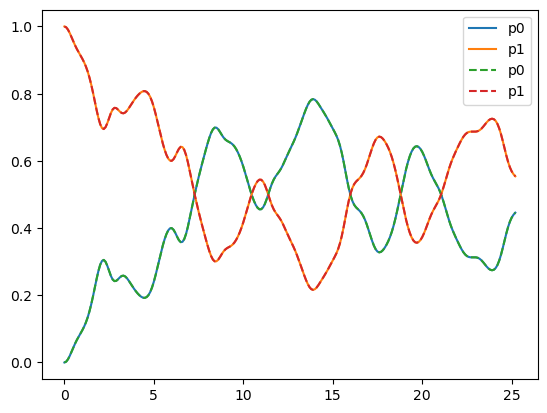

In [48]:
plt.plot(t_vals, p0)
plt.plot(t_vals, p1)
plt.plot(t_vals, pp0, '--')
plt.plot(t_vals, pp1, '--')
plt.legend(["p0","p1","p0","p1"])
plt.show()

$|1\rangle$ in computational basis, $|f^\text{coh}\rangle$ in coordinate basis

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.linalg import expm

def coherent(alpha_real_part:float, alpha_imag_part:float, x:np.ndarray, mass:float=1., omega:float=1., hbar:float=1.)->np.ndarray:
    '''static'''
    if not isinstance(x,np.ndarray):
        x = np.array(x)
    leading = (mass * omega / np.pi / hbar)**0.25 * np.exp(-mass * omega / 2 / hbar * (x - np.sqrt(2 * hbar / mass / omega) * alpha_real_part)**2)
    real = np.cos(np.sqrt(2 * mass * omega / hbar) * x * alpha_imag_part)
    imag = np.sin(np.sqrt(2 * mass * omega / hbar) * x * alpha_imag_part)
    result_real = leading * real
    result_imag = leading * imag
    result_abs = leading
    return result_real, result_imag, result_abs

def real_(alpha0:float, t:float, omega:float=1.)->float:
    result = np.real(alpha0) * np.cos(omega * t) + np.imag(alpha0) * np.sin(omega * t)
    return result

def imag_(alpha0:float, t:float, omega:float=1.)->float:
    result = np.imag(alpha0) * np.cos(omega * t) - np.real(alpha0) * np.sin(omega * t)
    return result

def coherentT(x:np.ndarray, t:float, mass:float=1., omega:float=1., hbar:float=1.)->np.ndarray:
    if not isinstance(x,np.ndarray):
        x = np.array(x)
    result = (mass * omega / np.pi / hbar)**0.25 * np.exp(-mass * omega / 2. / hbar * (x - np.sqrt(2 * hbar / mass / omega) * real_(t))**2) \
    * (np.cos(np.sqrt(2 * mass * omega / hbar) * imag_(t) * x) + 1j * np.sin(np.sqrt(2 * mass * omega / hbar) * imag_(t) * x))
    return result

sigma_x = np.array([[0,1],[1,0]])
sigma_z = np.array([[1,0],[0,-1]])
m = 1.
omega = 1.
hbar = 1.
gamma = 0.8
delta = 1.
alpha = -1.5
xmin, xmax = -10, 10
npoints = 200
x = np.linspace(xmin, xmax, npoints)
t_vals = np.arange(0, 8. * np.pi + 0.1, 0.1)
dt = 0.1

f_coh_real, f_coh_imag, f_coh_abs = coherent(np.real(alpha), np.imag(alpha), x,)
f_coh = f_coh_real + 1j * f_coh_imag
f_coh /= np.linalg.norm(f_coh)

potential = (np.diag(x) @ np.diag(x)) * m * omega**2 / 2.
kinetic = (np.diag([-2 for _ in range(npoints)],k=0) + np.diag([1 for _ in range(npoints - 1)],k=-1) + np.diag([1 for _ in range(npoints - 1)],k=1)) * -hbar**2 / 2. / m
H_bath = np.kron(np.identity(2), (potential + kinetic - np.identity(npoints) * (hbar * omega / 2.)))
H_sys = np.kron(delta / 2. * sigma_x, np.identity(npoints))
H_int = np.kron(sigma_z / 2., gamma * np.diag(x))
H_tot = H_sys + H_bath + H_int

f_sys = np.array([0,1])
f_tot = np.kron(f_sys, f_coh)

f_tot_t = [expm(-1j / hbar * H_tot * t_val) @ f_tot for t_val in t_vals]


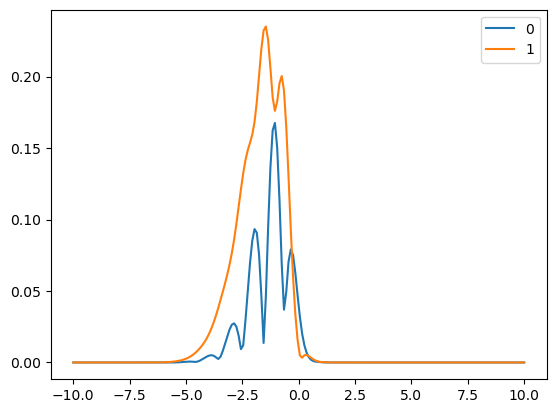

In [32]:
plt.plot(x, np.abs(f_tot_t[100][:npoints]))
plt.plot(x, np.abs(f_tot_t[100][npoints:]))
plt.legend(["0","1"])
plt.show()

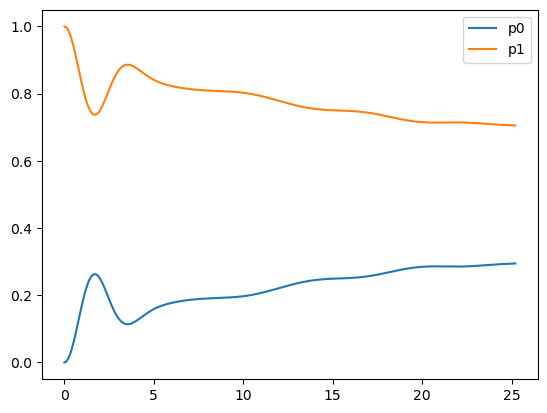

In [33]:
p0 = [sum(np.abs(f[:npoints])**2) for f in f_tot_t]
p1 = [sum(np.abs(f[npoints:])**2) for f in f_tot_t]

plt.plot(t_vals, p0)
plt.plot(t_vals, p1)
plt.legend(["p0","p1"])
plt.show()